In [1]:
import math
import pandas as pd
import random
import numpy as np
import requests
from random import sample, shuffle
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
from pyDOE2 import fullfact
from typing import List, Dict, Tuple, Any

In [2]:
data = pd.read_csv('./data/FinalData.csv')
data.head(5)

,ID,Name,Address,Latitude,Longitude,Opening Hours,Types,Rating,User Ratings Total
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,Blue Summer Hotel,"35 Tôn Thất Đạm, Xuân Hà, Thanh Khê, Đà Nẵng 5...",16.072062,108.201392,"['Monday: Open 24 hours', 'Tuesday: Open 24 ho...","['lodging', 'point_of_interest', 'establishment']",3.9,42.0
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,Vinapha 2 Hotel,"19 Phạm Hồng Thái, Hải Châu 1, Hải Châu, Đà Nẵ...",16.067351,108.221777,['Monday: 12:00\u202fAM\u2009–\u200911:59\u202...,"['lodging', 'point_of_interest', 'establishment']",3.0,93.0
2,ChIJ13MshlIYQjERM4sqFu8lvyA,Ribo Coffee,"05 Thái Thị Bôi, Chính Gián, Thanh Khê, Đà Nẵn...",16.068272,108.201195,['Monday: 6:30\u202fAM\u2009–\u200910:30\u202f...,"['cafe', 'food', 'point_of_interest', 'establi...",4.1,306.0
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,Mì Quảng Thi,"251 Hoàng Diệu, Nam Dương, Hải Châu, Đà Nẵng 5...",16.058546,108.217224,['Monday: 6:00\u202fAM\u2009–\u20091:29\u202fP...,"['restaurant', 'point_of_interest', 'food', 'e...",4.3,308.0
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,Chùa Linh Ứng,"Vườn Lâm Tỳ Ni, Hoàng Sa, Thọ Quang, Sơn Trà, ...",16.100261,108.277747,"['Monday: Open 24 hours', 'Tuesday: Open 24 ho...","['place_of_worship', 'point_of_interest', 'est...",4.7,1785.0


In [3]:
newData = data.loc[:, ["ID", "Name", "Latitude", "Longitude"]]
newData.head(5)

,ID,Name,Latitude,Longitude
0,ChIJ-3wY7lEYQjERrJ9wTeoa-WQ,Blue Summer Hotel,16.072062,108.201392
1,ChIJ-UBpozMYQjERDV3V1nrXEiM,Vinapha 2 Hotel,16.067351,108.221777
2,ChIJ13MshlIYQjERM4sqFu8lvyA,Ribo Coffee,16.068272,108.201195
3,ChIJ14kOf8kZQjERrdrrQPpiZKA,Mì Quảng Thi,16.058546,108.217224
4,ChIJ2aT3UqMXQjER_rVaqCoyyWU,Chùa Linh Ứng,16.100261,108.277747


In [4]:
#Cloudy Phan Dang Luu
latInit = 16.019110655988168
lngInit = 108.22903420822459

In [5]:
def haversineDistance(lat1, lng1, lat2, lng2):
    latRadian1 = math.radians(lat1)
    lngRadian1 = math.radians(lng1)
    latRadian2 = math.radians(lat2)
    lngRadian2 = math.radians(lng2)

    dlat = latRadian2 - latRadian1
    dlng = lngRadian2 - lngRadian1
    R = 6371e3

    a = math.sin(dlat/2) ** 2 + math.cos(latRadian1) * math.cos(latRadian2) * math.sin(dlng/2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c

In [6]:
def calFitness(routeDistance: float):
    return 1/(routeDistance + 1)

In [7]:
class Location:
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y =y

    def to_tupl(self) -> Tuple:
        return (self.x, self.y)

In [8]:
class Route:
    def __init__(self, route: List['Location']) -> None:
        self.route = route
        self.distance: float = 0.0
        self.fitness: float = 0.0
    
    def routeDistance(self) -> float:
        if self.distance == 0: 
            pathDistance = 0.0  
            for index in range(0, len(self.route) - 1):
                dist = haversineDistance(self.route[index].x, self.route[index].y, self.route[index + 1].x, self.route[index + 1].y)
                pathDistance+= dist
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self) -> float:
        if self.fitness == 0:
            self.fitness = calFitness(self.routeDistance())
        return self.fitness
    
    def coordinates(self) -> Tuple[List[float], List[float]]:
        x_list, y_list = [], []
        for location in self.route:
            x_list.append(location.to_tupl()[0])
            y_list.append(location.to_tupl()[1])
        return x_list, y_list

In [9]:
def nearestNeighborAlgorithm(data, n = 14):
    startPoint = (latInit, lngInit)
    listPoints = []
    listDetailsPoint = []

    currentPoint = startPoint
    listPoints.append(currentPoint)
    detailsPoint = [ 0, 'Cloudy', currentPoint]
    listDetailsPoint.append(detailsPoint)

    while(len(listPoints) < n):
        minDistance = float('inf')
        nextPoint = None
        name = None
        index = 0

        for i , row in data.iterrows():
            
            lat = row['Latitude']
            lng = row['Longitude']
            if(lat, lng) not in listPoints:
                dist = haversineDistance(currentPoint[0], currentPoint[1], lat, lng)
                
                if dist < minDistance:
                    minDistance = dist
                    nextPoint = (lat, lng)
                    name = row['Name']
                    index = i + 1
            
        if nextPoint is not None:
            currentPoint = nextPoint
            listPoints.append(currentPoint)
            detailsNewPoint = [index, name, currentPoint]
            listDetailsPoint.append(detailsNewPoint)

    endPoint = startPoint
    listPoints.append(endPoint)
    listDetailsPoint.append(detailsPoint)

    return listPoints, listDetailsPoint

In [10]:
def initPopulation(populationSize: int, listInitLocations: List = None) -> List[List['Location']]:
    population = []

    listSamples = list(range(1, len(listInitLocations) - 1))

    for _ in range(populationSize):
        if listInitLocations is not None:
            listRandoms = random.sample(listSamples, len(listSamples))
            newLocation = [listInitLocations[0]] + [listInitLocations[i] for i in listRandoms] + [listInitLocations[-1]]

            population.append(newLocation)

    return population

In [11]:
def rankRoutes(population: List[List['Location']]) -> List[Tuple[int, float]]:
    fitnessResults: Dict = {}
    for i in range(len(population)):
        fitnessResults[i] = Route(population[i]).routeFitness()

    return sorted(fitnessResults.items(), key=lambda x: x[1], reverse=True)

In [12]:
def touramentSelection(populationRanked: List[Tuple[int, float]], numElites: int = 0):
    df = pd.DataFrame(np.array(populationRanked), columns=["Index", "Fitness"])
    df["weights"] = 100 * df.Fitness / df.Fitness.sum()
    selection_results = df.sample(n=len(populationRanked)-numElites,
                                  replace=True,
                                  weights=df.weights
                                  ).values[:, 0]
    elite_results = df.iloc[0:numElites, 0].values
    selection_results = list(map(int, np.concatenate(
        (selection_results, elite_results)).tolist()))
    return selection_results

In [13]:
def mergedPoint(population: List[List['Location']], selection_results: List[int]) -> List[List['Location']]:
    output: List = []
    for i in range(len(selection_results)):
        index = selection_results[i]
        output.append(population[index])
    return output

In [14]:
def crossoverMix(parent1: List['Location'], parent2: List['Location']):
    point1, point2 = random.sample(range(1, len(parent1)-1), 2)
    begin = min(point1, point2)
    end = max(point1, point2)

    child1_begin = parent1[:begin]
    child1_end = parent1[end:]

    child1 = child1_begin + child1_end
    child2 = parent2[begin:end+1]

    child1_remain = [item for item in parent2[1:-1] if item not in child1]
    child2_remain = [item for item in parent1[1:-1] if item not in child2]

    child1 = child1_begin + child1_remain + child1_end
    child2 += child2_remain

    child2.insert(0, parent2[0])
    child2.append(parent2[0])

    return child1, child2

In [15]:
def crossoverPopulation(mergedPoint: List[List['Location']], numElites: int = 0):
    children: List = []
    numNonElite = len(mergedPoint) - numElites

    individuals = random.sample(mergedPoint, len(mergedPoint))

    for i in range(1, numElites + 1):
        children.append(mergedPoint[-i])

    for i in range(0, numNonElite):
        child1, child2 = crossoverMix(individuals[i], individuals[len(mergedPoint) -i -1])
        children.append(child1)

    return children

In [16]:
def mutation(individual: List['Location'], mutationRate):
    if random.random() < mutationRate:
        mutation_index_1, mutation_index_2 = random.sample(range(1, len(individual) - 1), 2)
        begin = min(mutation_index_1, mutation_index_2)
        end = max(mutation_index_1, mutation_index_2)

        individual_begin = individual[:begin]
        individual_end = individual[end+1:]

        individual_center = individual[begin:end+1]
        individual_center.reverse()
        
        individual = individual_begin + individual_center + individual_end

    return individual

In [17]:
def mutatePopulation(children: List[List['Location']], mutationRate: float = 0):
    mutatedPopulation: List = []

    for individual in range(0, len(children)):
        mutatedIndividual = mutation(children[individual], mutationRate)
        mutatedPopulation.append(mutatedIndividual)
    return mutatedPopulation

In [18]:
def nextGeneration(currentGen: List[List['Location']], numElites: int, mutationRate: float = 0):
    populationRanked = rankRoutes(currentGen)

    bestCurrentGenRoute = Route(currentGen[populationRanked[0][0]])
    bestCurrentGenFitness = bestCurrentGenRoute.routeFitness()
    bestCurrentGenDistance = bestCurrentGenRoute.routeDistance()

    selectionResults = touramentSelection(populationRanked, numElites)
    individuals = mergedPoint(currentGen, selectionResults)
    children = crossoverPopulation(individuals, numElites)
    nextGeneration = mutatePopulation(children)

    return nextGeneration, bestCurrentGenRoute, bestCurrentGenFitness, bestCurrentGenDistance

In [27]:
def geneticAlgorithm(populationSize: int = 1, numElites: int = 0, numGens: int = 0, mutationRate: float = 0.001, listInitLocations: List = None):
    population = initPopulation(populationSize, listInitLocations)
    bestInitialRoute = Route(population[rankRoutes(population)[0][0]])
    # print("Initial Distance: " + str(bestInitialRoute.routeDistance()))

    bestRouteByGen: List = []
    bestFitnessByGen: List = []
    bestDistanceByGen: List = []

    for _ in range(0, numGens):
        population, bestCurrentGenRoute, bestCurrentGenFitness, bestCurrentGenDistance = \
            nextGeneration(population, numElites, mutationRate)
        
        bestRouteByGen.append(bestCurrentGenRoute)
        bestFitnessByGen.append(bestCurrentGenFitness)
        bestDistanceByGen.append(bestCurrentGenDistance)

    bestFinalRoute = Route(population[rankRoutes(population)[0][0]])
    # print("Final Distance: " + str(bestFinalRoute.routeDistance()))

    params = [populationSize,  numElites, numGens, mutationRate, listInitLocations]
    return bestFinalRoute, bestInitialRoute, bestFitnessByGen, bestDistanceByGen, params

In [20]:
listInitialPoints = []
for i in range(10, 20):
    listPoints, listDetailsPoint = nearestNeighborAlgorithm(newData, i)
    listInitialPoints.append(listPoints)

In [40]:
listInitalLocations: List[List[Location]] = []
for listPoint in listInitialPoints:
    listInitalLocation = [Location(i[0], i[1]) for i in listPoint]
    listInitalLocations.append(listInitalLocation)

In [22]:
listFitness = []
for i in listInitalLocations:
    bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, 0.005, i)
    listFitness.append(bfr.routeFitness)

[<__main__.Location object at 0x7f717f7fa320>, <__main__.Location object at 0x7f717f7f98a0>, <__main__.Location object at 0x7f717f7f9270>, <__main__.Location object at 0x7f717f7fa770>, <__main__.Location object at 0x7f717f7fa1d0>, <__main__.Location object at 0x7f717f7faf20>, <__main__.Location object at 0x7f717f7f8b80>, <__main__.Location object at 0x7f717f7fa590>, <__main__.Location object at 0x7f717f7fb760>, <__main__.Location object at 0x7f717f7f95d0>, <__main__.Location object at 0x7f717f7f9540>]
[<__main__.Location object at 0x7f717f7f81f0>, <__main__.Location object at 0x7f717f7fb3d0>, <__main__.Location object at 0x7f717f7f99c0>, <__main__.Location object at 0x7f717f7f8700>, <__main__.Location object at 0x7f717f7fbd60>, <__main__.Location object at 0x7f717f7f9420>, <__main__.Location object at 0x7f717f7fba30>, <__main__.Location object at 0x7f717f7f9ea0>, <__main__.Location object at 0x7f717f7fb310>, <__main__.Location object at 0x7f717f7fb910>, <__main__.Location object at 0x7

In [23]:
bestDistanceByMutation = []
mutations = []
numPops = []
numGens = []
numElites = []

In [76]:
numPop = [1000, 1500, 2000, 2500, 3000]
numElite = [400, 500]
numGen = [50, 100]

In [108]:
store = bestDistanceByMutation

In [122]:
for elite in numElite:
    for gen in numGen:
        i = 0.001
        while(i <= 0.3):
            bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(numPop[4], elite, gen, i, listInitalLocations)
            bestDistanceByMutation.append(bfr.routeDistance())
            mutations.append(i)
            numElites.append(elite)
            numGens.append(gen)
            numPops.append(numPop[4])
            i += 0.003


In [60]:
fitness = []
for i in range(0, len(bestDistanceByMutation)):
    fitness.append(1/(bestDistanceByMutation[i]+1)) 
df = pd.read_csv('./data/distance.csv')
for i in df['bestDistanceByMutation']:
    fitness.append(1/(i+1))
df['fitness'] = fitness
df


,numPops,numGens,numElites,muations,bestDistanceByMutation,fitness
0,1000,50,400,0.001,8360.936516,0.00012
1,1000,50,400,0.004,8360.936516,0.00012
2,1000,50,400,0.007,8360.936516,0.00012
3,1000,50,400,0.010,8360.936516,0.00012
4,1000,50,400,0.013,8363.922600,0.00012
...,...,...,...,...,...,...
2001,3000,100,500,0.286,8360.936516,0.00012
2002,3000,100,500,0.289,8360.936516,0.00012
2003,3000,100,500,0.292,8360.936516,0.00012
2004,3000,100,500,0.295,8360.936516,0.00012


In [ ]:
bestDistanceByMutation = []
i = 0.001
while(i <= 0.3):
    bfr, brbg, bfbg, bdbg, params = geneticAlgorithm(3000, 500, 50, i, listInitalLocations)
    bestDistanceByMutation.append(bfr.routeDistance())
    i += 0.001

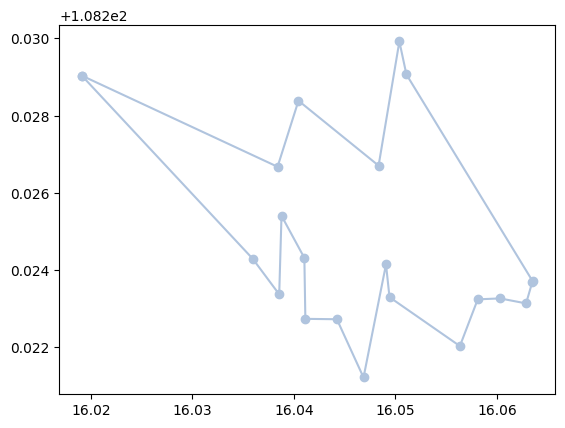

In [23]:
x, y = bfr.coordinates()
plt.plot(x, y, **{'color': 'lightsteelblue', 'marker': 'o'})
plt.show()

In [24]:
def distancePlot(bestDistanceByGen: List[int], params: List):
    plt.plot(bestDistanceByGen)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    s = "popSize: " + str(params[0]) + "\nnumCities: " + str(params[1]) + \
        "\nnumGens: " + str(params[3]) + "\nmutationRate: " + str(params[4])
    # plt.text(s)
    # plt.text(0, bestDistanceByGen[0], round(bestDistanceByGen[0],1))
    plt.text(len(bestDistanceByGen),
             bestDistanceByGen[-1], round(bestDistanceByGen[-1],1))
    plt.show()

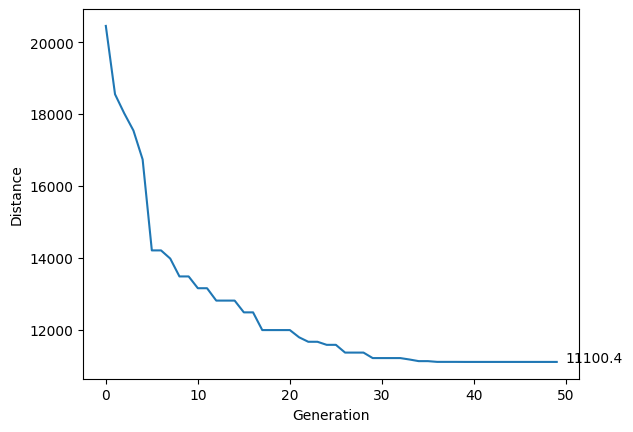

In [25]:
distancePlot(bdbg, params)

In [25]:
def fitnessePlot(bestDistanceByFitness: List[int], xAxis: List[int], params: List):
    plt.plot(xAxis, bestDistanceByFitness)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    s = "popSize: " + str(params[0]) + "\nnumCities: " + str(params[1]) + \
        "\nnumGens: " + str(params[3]) + "\nmutationRate: " + str(params[4])
    # plt.text(s)
    # plt.text(0, bestDistanceByFitness[0], round(bestDistanceByFitness[0],1))
    # plt.text(len(bestDistanceByFitness),
            #  bestDistanceByFitness[-1], round(bestDistanceByFitness[-1],1))
    plt.show()

299
299


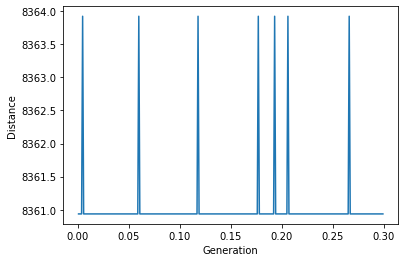

In [36]:
i = 0.001
xAxis = []
while(i <= 0.3):
    xAxis.append(i)
    i += 0.001
print(len(bestDistanceByMutation))
print(len(xAxis))
fitnessePlot(bestDistanceByMutation, xAxis, params)

100
100


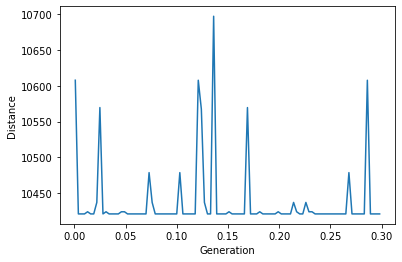

In [51]:
i = 0.001
xAxis = []
while(i <= 0.3):
    xAxis.append(i)
    i += 0.003
print(len(bestDistanceByMutation))
print(len(xAxis))
fitnessePlot(bestDistanceByMutation, xAxis, params)

100
100


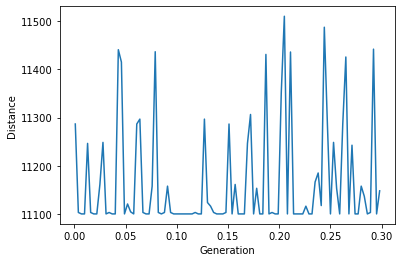

In [57]:
i = 0.001
xAxis = []
while(i <= 0.3):
    xAxis.append(i)
    i += 0.003
print(len(bestDistanceByMutation))
print(len(xAxis))
fitnessePlot(bestDistanceByMutation, xAxis, params)

In [61]:
trainingData = []
for i in range(500):
    listRandoms = newData.sample(22)
    listPoints = []
    for i , row in listRandoms.iterrows():    
        lat = row['Latitude']
        lng = row['Longitude']
        listPoints.append((lat, lng))
    trainingData.append(listPoints)
trainingData[0]

[(16.0680564, 108.2143082),
 (16.0673508, 108.2217765),
 (16.0682387, 108.2293969),
 (16.0581055, 108.2232435),
 (16.0590964, 108.2095965),
 (16.0410321, 108.2243161),
 (16.0626391, 108.2186137),
 (16.0585457, 108.2172243),
 (16.0722637, 108.208374),
 (16.0616075, 108.2193397),
 (16.0750263, 108.222222),
 (16.0592996, 108.1720359),
 (16.0388189, 108.2448648),
 (16.0552828, 108.2086722),
 (16.0638028, 108.2196298),
 (16.0546774, 108.1716124),
 (16.0566137, 108.2117756),
 (16.0686057, 108.192376),
 (16.0581999, 108.2189718),
 (16.0642548, 108.2298186),
 (16.1566197, 108.1093217),
 (16.0659789, 108.2191595)]

In [62]:
df1 = pd.DataFrame({'location': listInitalLocations, 'fitness': listFitness})
df

,numPops,numGens,numElites,muations,bestDistanceByMutation,fitness
0,1000,50,400,0.001,8360.936516,0.00012
1,1000,50,400,0.004,8360.936516,0.00012
2,1000,50,400,0.007,8360.936516,0.00012
3,1000,50,400,0.010,8360.936516,0.00012
4,1000,50,400,0.013,8363.922600,0.00012
...,...,...,...,...,...,...
2001,3000,100,500,0.286,8360.936516,0.00012
2002,3000,100,500,0.289,8360.936516,0.00012
2003,3000,100,500,0.292,8360.936516,0.00012
2004,3000,100,500,0.295,8360.936516,0.00012


In [83]:
def genetic(mutationRate, populationSize, numElites,numGens, listInitLocations):
    bfr, brbg, bfbg, bdbg, params =geneticAlgorithm(mutationRate=mutationRate, populationSize=populationSize, numElites=numElites,numGens=numGens, listInitLocations=listInitLocations)
    return bfr

In [91]:
from sklearn.base import BaseEstimator, RegressorMixin

class GeneticAlgorithmRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, mutationRate: float =0.0, populationSize: int =1, numElites: int=0, numGens: int=0): # khai báo các siêu tham số của thuật toán di truyền của bạn
        self.mutationRate = mutationRate
        self.populationSize = populationSize
        self.numElites = numElites
        self.numGens = numGens
        self.ga = None
        self.best_fitness_ = None
        # self.genetic_algorithm = genetic(mutationRate=self.mutationRate, populationSize=self.populationSize, numElites=self.numElites,numGens=self.numGens, listInitLocations=listInitalLocations[0]) # khởi tạo thuật toán di truyền

    def fit(self, X, y): # triển khai phương thức fit()
        self.ga = genetic(mutationRate=self.mutationRate, populationSize=self.populationSize, numElites=self.numElites,numGens=self.numGens, listInitLocations=listInitalLocations[0])
        
        # Train the genetic algorithm on the data
        # self.ga.evolve(X, y)
        
        # Set the best fitness score
        self.best_fitness_ = self.ga.routeFitness
        
        return self

    def predict(self, X): # triển khai phương thức predict()
        return self.genetic_algorithm.predict(X)

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the TSP dataset
X1 = df.drop(['fitness'], axis=1)
y1 = df['fitness']

# Set up the genetic algorithm with a fixed crossover rate of 0.8
ga = GeneticAlgorithmRegressor()

# Define the parameter grid for mutation rate
param_grid = {
    'mutationRate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3],
    'populationSize': [500, 1000, 1500, 2000],
    'numElites': [300, 350, 400, 450, 500],
    'numGens': [ 50, 100, 150],
}

# Set up the grid search
grid_search = GridSearchCV(ga, param_grid, cv=5)

# Fit the grid search to the dataset
grid_search.fit(X1, y1)
grid_search.best_estimator_

# Print the best mutation rate
# print('Best mutation rate:', grid_search.best_estimator_)

/home/gracie/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gracie/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/gracie/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/gracie/.local/lib/python3.10/site-packages/sklearn/base.py", line 722, in score
    y_pred = self.predict(X)
  File "/tmp/ipykernel_27501/1061728009.py", line 25, in predict
    return self.genetic_algorithm.predict(X)
AttributeError: 'GeneticAlgorithmRegressor' object has no attribute 'genetic_algorithm'

  warnings.warn(
/home/gracie/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.p

GeneticAlgorithmRegressor(numElites=500, numGens=100, populationSize=1000)